In [3]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [3]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [4]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [5]:
lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
dwane_preds = pd.read_csv("Prediction_csv/click_predictions_narrow.csv")
lasso_preds = pd.read_csv("Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")
ridge_preds = pd.read_csv("Prediction_csv/ridge_basebid.csv", index_col  = "Unnamed: 0")
elasticnet_preds = pd.read_csv("Prediction_csv/elasticnet_basebid.csv", index_col  = "Unnamed: 0")
rfg_preds = pd.read_csv("Prediction_csv/rfg_basebid.csv", index_col  = "Unnamed: 0")
xgbr_preds = pd.read_csv("Prediction_csv/xgb_basebid.csv", index_col  = "Unnamed: 0")

In [6]:
# # Ensemble model
# ensemble_prob =xgb_preds["click_proba"]*dwane_preds["click_proba"]
# ensemble_pCTR_preds = pd.DataFrame(columns = ["bidid", "click_proba"], 
#                                    data = list(zip(validation["bidid"], ensemble_prob)))

# ensemble_basebid = 0.2* (lasso_preds["predicted_payprice"] + ridge_preds["predicted_payprice"] + elasticnet_preds["predicted_payprice"] +\
#                   rfg_preds["predicted_payprice"] + xgbr_preds["predicted_payprice"])
# ensemble_basebid_preds = pd.DataFrame(columns = ["bidid", "predicted_payprice"], 
#                                    data = list(zip(validation["bidid"], ensemble_basebid)))

In [7]:
base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
avgCTR = train["click"].sum()*100/train.shape[0]

In [8]:
print("Base bid: {}, avgCTR: {}, ratio: {}".format(base_bid, avgCTR, base_bid/avgCTR))

Base bid: 105.46402677077523, avgCTR: 0.07375623256619447, ratio: 1429.899862037066


In [16]:
thresh_pCTR = np.linspace(0.05, 0.9, 50)
thresh_pCTR

array([0.05      , 0.06734694, 0.08469388, 0.10204082, 0.11938776,
       0.13673469, 0.15408163, 0.17142857, 0.18877551, 0.20612245,
       0.22346939, 0.24081633, 0.25816327, 0.2755102 , 0.29285714,
       0.31020408, 0.32755102, 0.34489796, 0.3622449 , 0.37959184,
       0.39693878, 0.41428571, 0.43163265, 0.44897959, 0.46632653,
       0.48367347, 0.50102041, 0.51836735, 0.53571429, 0.55306122,
       0.57040816, 0.5877551 , 0.60510204, 0.62244898, 0.63979592,
       0.65714286, 0.6744898 , 0.69183673, 0.70918367, 0.72653061,
       0.74387755, 0.76122449, 0.77857143, 0.79591837, 0.81326531,
       0.83061224, 0.84795918, 0.86530612, 0.88265306, 0.9       ])

# Strategies

In [17]:
def Strategy3(sub_pCTR, sub_basebid, thresh):
    
    avgCTR = sub_pCTR["click_proba"].mean()
    sub_pCTR_ = sub_pCTR.copy()
    sub_pCTR_["click_proba"] = sub_pCTR_["click_proba"].map(lambda x: 0 if x < thresh else np.exp(x))
    bidprice = (sub_pCTR_["click_proba"] * sub_basebid["predicted_payprice"]) / avgCTR
    return bidprice

# Evaluate Results

In [18]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid, thresh):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["basebid_predicted"] = submission_basebid["predicted_payprice"]
    validation_check["bidprice_predicted"] = Strategy3(submission_pCTR, submission_basebid, thresh)
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    if clicks != 0:
        cpc = cost/clicks/1000
    else:
        cpc = 0
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, cost,\
                                                                                                                     ctr, cpm, cpc))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [19]:
pCTR_preds = [lr_preds, rf_preds, xgb_preds, dwane_preds]
basebid_preds = [lasso_preds, ridge_preds, elasticnet_preds, rfg_preds, xgbr_preds]
pCTR_model_names = ["Logistic Regression", "Random Forest", "XGBoost", "Forest of RF"]
basebid_model_names = ["Lasso", "Ridge", "Elastic Net", "Random Forest Regressor", "XGBoost Regressor"]
results = pd.DataFrame(columns = ["pCTR_model", "basebid_model", "thresh", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0
j=0
k=0

start = time.time()

for pCTR_pred in pCTR_preds:
    for basebid_pred in basebid_preds:
        for thresh in thresh_pCTR:
            
            # Strategy 3
            validation_check = ValidationDataFrame(pCTR_pred, basebid_pred, thresh)
            print("\033[1m pCTR model: {} \033[0m, \033[1m basebid model: {} \033[0m, \033[1m pCTR thresh: {} \033[0m ".format(pCTR_model_names[i], basebid_model_names[j], thresh))
            impressions, clicks, cost, auctions_participated, ctr, cpm, cpc= ValidateStrategy(validation_check)
            results.loc[k] = [pCTR_model_names[i], basebid_model_names[j], thresh, impressions, clicks, cost, ctr, cpm, cpc]
            k+=1
        j+=1
        
        
    j=0    
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.05  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82376 | Clicks: 53 | Cost: 6249967 | CTR: 0.06433912790133048 | CPM: 75.8712124890745 | CPC: 117.92390566037736


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.0673469387755102  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82376 | Clicks: 53 | Cost: 6249967 | CTR: 0.06433912790133048 | CPM: 75.8712124890745 | CPC: 117.92390566037736


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.08469387755102041  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82376 | Clicks: 53 | Cost: 6249967 | CTR: 0.06433912790133048 | CPM: 75.8712124890745 | CPC: 117.92390566037736


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.10204081632653061  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82376 | Clicks: 53 | Cost: 624

Strategy statistics:
Auctions participated: 303925 | Impressions: 17193 | Clicks: 89 | Cost: 1300469 | CTR: 0.5176525330076194 | CPM: 75.6394462862793 | CPC: 14.612011235955057


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.553061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 16220 | Clicks: 85 | Cost: 1218733 | CTR: 0.5240443896424167 | CPM: 75.13766954377311 | CPC: 14.338035294117647


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.5704081632653062  
Strategy statistics:
Auctions participated: 303925 | Impressions: 15333 | Clicks: 82 | Cost: 1150593 | CTR: 0.5347942346572752 | CPM: 75.04030522402661 | CPC: 14.031621951219513


 pCTR model: Logistic Regression ,  basebid model: Lasso ,  pCTR thresh: 0.5877551020408164  
Strategy statistics:
Auctions participated: 303925 | Impressions: 14796 | Clicks: 79 | Cost: 1100181 | CTR: 0.5339280886726142 | CPM: 74.35665044606651 | CPC: 13.926341772151899




Strategy statistics:
Auctions participated: 303925 | Impressions: 82248 | Clicks: 54 | Cost: 6249993 | CTR: 0.06565509191712868 | CPM: 75.98960461044645 | CPC: 115.74061111111111


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.18877551020408162  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82248 | Clicks: 54 | Cost: 6249993 | CTR: 0.06565509191712868 | CPM: 75.98960461044645 | CPC: 115.74061111111111


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.2061224489795918  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82248 | Clicks: 54 | Cost: 6249993 | CTR: 0.06565509191712868 | CPM: 75.98960461044645 | CPC: 115.74061111111111


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.22346938775510206  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82248 | Clicks: 54 | Cost: 6249993 | CTR: 0.06565509191712868 | CPM: 75.98960461044645 | CPC: 115.740611111

Strategy statistics:
Auctions participated: 303925 | Impressions: 5252 | Clicks: 40 | Cost: 421788 | CTR: 0.7616146230007617 | CPM: 80.30997715156131 | CPC: 10.5447


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.6744897959183673  
Strategy statistics:
Auctions participated: 303925 | Impressions: 837 | Clicks: 14 | Cost: 72247 | CTR: 1.6726403823178018 | CPM: 86.31660692951016 | CPC: 5.1605


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.6918367346938776  
Strategy statistics:
Auctions participated: 303925 | Impressions: 327 | Clicks: 6 | Cost: 24859 | CTR: 1.834862385321101 | CPM: 76.02140672782875 | CPC: 4.143166666666667


 pCTR model: Logistic Regression ,  basebid model: Ridge ,  pCTR thresh: 0.7091836734693878  
Strategy statistics:
Auctions participated: 303925 | Impressions: 259 | Clicks: 6 | Cost: 15842 | CTR: 2.3166023166023164 | CPM: 61.166023166023166 | CPC: 2.6403333333333334


 pCTR model: Logistic Regression ,  ba

 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.29285714285714287  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81960 | Clicks: 52 | Cost: 6249957 | CTR: 0.0634455832113226 | CPM: 76.25618594436311 | CPC: 120.19148076923076


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.31020408163265306  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81960 | Clicks: 52 | Cost: 6249957 | CTR: 0.0634455832113226 | CPM: 76.25618594436311 | CPC: 120.19148076923076


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.32755102040816325  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81960 | Clicks: 52 | Cost: 6249957 | CTR: 0.0634455832113226 | CPM: 76.25618594436311 | CPC: 120.19148076923076


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.34489795918367344  
Strategy statistics:
Auctions participated: 303925 | Imp

Strategy statistics:
Auctions participated: 303925 | Impressions: 139 | Clicks: 3 | Cost: 4525 | CTR: 2.158273381294964 | CPM: 32.55395683453237 | CPC: 1.5083333333333333


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.7785714285714286  
Strategy statistics:
Auctions participated: 303925 | Impressions: 124 | Clicks: 3 | Cost: 3210 | CTR: 2.4193548387096775 | CPM: 25.887096774193548 | CPC: 1.07


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.7959183673469388  
Strategy statistics:
Auctions participated: 303925 | Impressions: 124 | Clicks: 3 | Cost: 3210 | CTR: 2.4193548387096775 | CPM: 25.887096774193548 | CPC: 1.07


 pCTR model: Logistic Regression ,  basebid model: Elastic Net ,  pCTR thresh: 0.8132653061224491  
Strategy statistics:
Auctions participated: 303925 | Impressions: 98 | Clicks: 2 | Cost: 1608 | CTR: 2.0408163265306123 | CPM: 16.408163265306122 | CPC: 0.804


 pCTR model: Logistic Regression ,  basebid 

 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.3795918367346939  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82819 | Clicks: 54 | Cost: 6249989 | CTR: 0.06520242939422113 | CPM: 75.46564194206644 | CPC: 115.74053703703704


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.39693877551020407  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81921 | Clicks: 59 | Cost: 6249983 | CTR: 0.07202060521722146 | CPM: 76.29280648429585 | CPC: 105.9319152542373


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.41428571428571426  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82119 | Clicks: 70 | Cost: 6249991 | CTR: 0.08524214858924244 | CPM: 76.10895164334686 | CPC: 89.28558571428572


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.4316326530612245  
Strategy 

Strategy statistics:
Auctions participated: 303925 | Impressions: 88 | Clicks: 1 | Cost: 824 | CTR: 1.1363636363636365 | CPM: 9.363636363636363 | CPC: 0.824


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8479591836734695  
Strategy statistics:
Auctions participated: 303925 | Impressions: 88 | Clicks: 1 | Cost: 824 | CTR: 1.1363636363636365 | CPM: 9.363636363636363 | CPC: 0.824


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8653061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82 | Clicks: 0 | Cost: 0 | CTR: 0.0 | CPM: 0.0 | CPC: 0


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8826530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 82 | Clicks: 0 | Cost: 0 | CTR: 0.0 | CPM: 0.0 | CPC: 0


 pCTR model: Logistic Regression ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.9  
S

 pCTR model: Logistic Regression ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4489795918367347  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79876 | Clicks: 93 | Cost: 6249999 | CTR: 0.1164304672241975 | CPM: 78.2462692172868 | CPC: 67.20429032258065


 pCTR model: Logistic Regression ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4663265306122449  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79688 | Clicks: 106 | Cost: 6249995 | CTR: 0.13301877321554062 | CPM: 78.43081768898705 | CPC: 58.96221698113208


 pCTR model: Logistic Regression ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4836734693877551  
Strategy statistics:
Auctions participated: 303925 | Impressions: 50317 | Clicks: 125 | Cost: 3956165 | CTR: 0.24842498559135084 | CPM: 78.62481864976051 | CPC: 31.64932


 pCTR model: Logistic Regression ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.5010204081632653  
Strategy statistics:
Auctions participated: 3

 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.0673469387755102  
Strategy statistics:
Auctions participated: 303925 | Impressions: 77002 | Clicks: 74 | Cost: 6249802 | CTR: 0.09610139996363731 | CPM: 81.16415158047843 | CPC: 84.45678378378379


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.08469387755102041  
Strategy statistics:
Auctions participated: 303925 | Impressions: 75873 | Clicks: 87 | Cost: 6249796 | CTR: 0.11466529595508283 | CPM: 82.37180551711413 | CPC: 71.8367356321839


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.10204081632653061  
Strategy statistics:
Auctions participated: 303925 | Impressions: 74813 | Clicks: 106 | Cost: 6249815 | CTR: 0.1416866052691377 | CPM: 83.53915763303169 | CPC: 58.96051886792453


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.11938775510204082  
Strategy statistics:
Auctions participated: 303925 | Impressions: 73712 | Clicks: 131 | Cost: 6249783 | CT

Strategy statistics:
Auctions participated: 303925 | Impressions: 4045 | Clicks: 61 | Cost: 270651 | CTR: 1.508034610630408 | CPM: 66.91001236093943 | CPC: 4.436901639344263


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.5704081632653062  
Strategy statistics:
Auctions participated: 303925 | Impressions: 3723 | Clicks: 57 | Cost: 246692 | CTR: 1.53102336825141 | CPM: 66.26161697555735 | CPC: 4.327929824561403


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.5877551020408164  
Strategy statistics:
Auctions participated: 303925 | Impressions: 3397 | Clicks: 51 | Cost: 224866 | CTR: 1.5013246982631734 | CPM: 66.19546658816603 | CPC: 4.40913725490196


 pCTR model: Random Forest ,  basebid model: Lasso ,  pCTR thresh: 0.6051020408163266  
Strategy statistics:
Auctions participated: 303925 | Impressions: 3117 | Clicks: 44 | Cost: 204654 | CTR: 1.4116137311517485 | CPM: 65.65736284889317 | CPC: 4.651227272727273


 pCTR model: Random Forest ,  ba

Strategy statistics:
Auctions participated: 303925 | Impressions: 38332 | Clicks: 140 | Cost: 3364366 | CTR: 0.36523009495982467 | CPM: 87.76912240425754 | CPC: 24.031185714285716


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.2061224489795918  
Strategy statistics:
Auctions participated: 303925 | Impressions: 31684 | Clicks: 135 | Cost: 2778315 | CTR: 0.42608256533266003 | CPM: 87.68826537053403 | CPC: 20.58011111111111


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.22346938775510206  
Strategy statistics:
Auctions participated: 303925 | Impressions: 26479 | Clicks: 132 | Cost: 2302386 | CTR: 0.4985082518221987 | CPM: 86.95139544544733 | CPC: 17.44231818181818


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.24081632653061225  
Strategy statistics:
Auctions participated: 303925 | Impressions: 22417 | Clicks: 126 | Cost: 1931817 | CTR: 0.5620734264174511 | CPM: 86.17642860329214 | CPC: 15.331880952380953


 pCTR mode

Strategy statistics:
Auctions participated: 303925 | Impressions: 1855 | Clicks: 17 | Cost: 118350 | CTR: 0.9164420485175202 | CPM: 63.80053908355795 | CPC: 6.961764705882353


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.7091836734693878  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1658 | Clicks: 16 | Cost: 105106 | CTR: 0.9650180940892642 | CPM: 63.393244873341374 | CPC: 6.569125


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.726530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1448 | Clicks: 14 | Cost: 90703 | CTR: 0.9668508287292817 | CPM: 62.64019337016575 | CPC: 6.478785714285714


 pCTR model: Random Forest ,  basebid model: Ridge ,  pCTR thresh: 0.7438775510204082  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1290 | Clicks: 10 | Cost: 80155 | CTR: 0.7751937984496124 | CPM: 62.13565891472868 | CPC: 8.0155


 pCTR model: Random Forest ,  basebid model: Ridge

Strategy statistics:
Auctions participated: 303925 | Impressions: 11895 | Clicks: 112 | Cost: 949456 | CTR: 0.9415720891130728 | CPM: 79.81975620008407 | CPC: 8.477285714285713


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.34489795918367344  
Strategy statistics:
Auctions participated: 303925 | Impressions: 10808 | Clicks: 111 | Cost: 847022 | CTR: 1.0270170244263508 | CPM: 78.369911176906 | CPC: 7.630828828828829


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.36224489795918363  
Strategy statistics:
Auctions participated: 303925 | Impressions: 9913 | Clicks: 104 | Cost: 762698 | CTR: 1.0491274084535458 | CPM: 76.93917078583678 | CPC: 7.333634615384615


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.3795918367346939  
Strategy statistics:
Auctions participated: 303925 | Impressions: 9106 | Clicks: 103 | Cost: 687860 | CTR: 1.1311223369207115 | CPM: 75.53920491983308 | CPC: 6.678252427184466


 pCT

Strategy statistics:
Auctions participated: 303925 | Impressions: 625 | Clicks: 4 | Cost: 35231 | CTR: 0.64 | CPM: 56.3696 | CPC: 8.80775


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.8479591836734695  
Strategy statistics:
Auctions participated: 303925 | Impressions: 510 | Clicks: 4 | Cost: 27635 | CTR: 0.7843137254901961 | CPM: 54.18627450980392 | CPC: 6.90875


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.8653061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 419 | Clicks: 4 | Cost: 21406 | CTR: 0.954653937947494 | CPM: 51.088305489260144 | CPC: 5.3515


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.8826530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 338 | Clicks: 4 | Cost: 15464 | CTR: 1.183431952662722 | CPM: 45.751479289940825 | CPC: 3.866


 pCTR model: Random Forest ,  basebid model: Elastic Net ,  pCTR thresh: 0.9  
Strategy s

Strategy statistics:
Auctions participated: 303925 | Impressions: 6643 | Clicks: 81 | Cost: 474899 | CTR: 1.2193286165888906 | CPM: 71.48863465301821 | CPC: 5.862950617283951


 pCTR model: Random Forest ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.4663265306122449  
Strategy statistics:
Auctions participated: 303925 | Impressions: 6092 | Clicks: 78 | Cost: 428586 | CTR: 1.2803676953381484 | CPM: 70.35226526592253 | CPC: 5.494692307692308


 pCTR model: Random Forest ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.4836734693877551  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5681 | Clicks: 75 | Cost: 395537 | CTR: 1.320190107375462 | CPM: 69.62453793346242 | CPC: 5.273826666666666


 pCTR model: Random Forest ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.5010204081632653  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5214 | Clicks: 69 | Cost: 358259 | CTR: 1.3233601841196778 | CPM: 68.71097046413502 | 

 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.0673469387755102  
Strategy statistics:
Auctions participated: 303925 | Impressions: 77046 | Clicks: 74 | Cost: 6249987 | CTR: 0.0960465176647717 | CPM: 81.12020091893154 | CPC: 84.45928378378379


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.08469387755102041  
Strategy statistics:
Auctions participated: 303925 | Impressions: 75881 | Clicks: 87 | Cost: 6249994 | CTR: 0.11465320699516347 | CPM: 82.36573055178503 | CPC: 71.83901149425287


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.10204081632653061  
Strategy statistics:
Auctions participated: 303925 | Impressions: 74833 | Clicks: 106 | Cost: 6249978 | CTR: 0.14164873785629334 | CPM: 83.51900899335854 | CPC: 58.96205660377358


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.11938775510204082  
Strategy statistics:
Auctions participated: 303925 | Impr

Strategy statistics:
Auctions participated: 303925 | Impressions: 4425 | Clicks: 65 | Cost: 296842 | CTR: 1.4689265536723164 | CPM: 67.08293785310734 | CPC: 4.5668


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.553061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 4045 | Clicks: 61 | Cost: 270651 | CTR: 1.508034610630408 | CPM: 66.91001236093943 | CPC: 4.436901639344263


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.5704081632653062  
Strategy statistics:
Auctions participated: 303925 | Impressions: 3723 | Clicks: 57 | Cost: 246692 | CTR: 1.53102336825141 | CPM: 66.26161697555735 | CPC: 4.327929824561403


 pCTR model: Random Forest ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.5877551020408164  
Strategy statistics:
Auctions participated: 303925 | Impressions: 3397 | Clicks: 51 | Cost: 224866 | CTR: 1.5013246982631734 | CPM: 66.19546658816603 | CPC: 4.40913725490196


 pCTR mo

Strategy statistics:
Auctions participated: 303925 | Impressions: 16205 | Clicks: 115 | Cost: 1407281 | CTR: 0.7096575131132367 | CPM: 86.84239432273989 | CPC: 12.237226086956522


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.18877551020408162  
Strategy statistics:
Auctions participated: 303925 | Impressions: 14079 | Clicks: 114 | Cost: 1213414 | CTR: 0.8097165991902834 | CPM: 86.18609276227005 | CPC: 10.643982456140352


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.2061224489795918  
Strategy statistics:
Auctions participated: 303925 | Impressions: 12393 | Clicks: 114 | Cost: 1061122 | CTR: 0.9198741224885015 | CPM: 85.62269022835471 | CPC: 9.308087719298246


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.22346938775510206  
Strategy statistics:
Auctions participated: 303925 | Impressions: 10922 | Clicks: 110 | Cost: 930339 | CTR: 1.0071415491668192 | CPM: 85.18027833730086 | CPC: 8.457627272727274


 pCTR model: XGBoost ,  basebid

Strategy statistics:
Auctions participated: 303925 | Impressions: 1297 | Clicks: 81 | Cost: 108878 | CTR: 6.245181187355436 | CPM: 83.94602929838088 | CPC: 1.3441728395061727


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.6918367346938776  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1205 | Clicks: 80 | Cost: 101320 | CTR: 6.639004149377594 | CPM: 84.08298755186722 | CPC: 1.2665


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.7091836734693878  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1113 | Clicks: 80 | Cost: 94086 | CTR: 7.187780772686433 | CPM: 84.53369272237197 | CPC: 1.176075


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.726530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1031 | Clicks: 78 | Cost: 87593 | CTR: 7.565470417070805 | CPM: 84.95926285160039 | CPC: 1.1229871794871795


 pCTR model: XGBoost ,  basebid model: Lasso ,  pCTR thresh: 0.74387755

Strategy statistics:
Auctions participated: 303925 | Impressions: 5971 | Clicks: 99 | Cost: 500583 | CTR: 1.6580137330430413 | CPM: 83.83570591190755 | CPC: 5.056393939393939


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.34489795918367344  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5493 | Clicks: 98 | Cost: 458777 | CTR: 1.7840888403422537 | CPM: 83.52029856180593 | CPC: 4.681397959183673


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.36224489795918363  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5067 | Clicks: 95 | Cost: 420590 | CTR: 1.8748766528517862 | CPM: 83.00572330767713 | CPC: 4.427263157894736


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.3795918367346939  
Strategy statistics:
Auctions participated: 303925 | Impressions: 4664 | Clicks: 94 | Cost: 389444 | CTR: 2.0154373927958833 | CPM: 83.5 | CPC: 4.143021276595745


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thre

Strategy statistics:
Auctions participated: 303925 | Impressions: 570 | Clicks: 74 | Cost: 46712 | CTR: 12.982456140350877 | CPM: 81.95087719298246 | CPC: 0.6312432432432432


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.8653061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 521 | Clicks: 74 | Cost: 42359 | CTR: 14.203454894433781 | CPM: 81.30326295585412 | CPC: 0.5724189189189189


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.8826530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 479 | Clicks: 72 | Cost: 38689 | CTR: 15.031315240083508 | CPM: 80.77035490605428 | CPC: 0.5373472222222222


 pCTR model: XGBoost ,  basebid model: Ridge ,  pCTR thresh: 0.9  
Strategy statistics:
Auctions participated: 303925 | Impressions: 440 | Clicks: 69 | Cost: 34849 | CTR: 15.681818181818182 | CPM: 79.20227272727273 | CPC: 0.5050579710144928


 pCTR model: XGBoost ,  basebid model: Elastic Net ,  pCTR thresh

Strategy statistics:
Auctions participated: 303925 | Impressions: 2084 | Clicks: 84 | Cost: 169873 | CTR: 4.030710172744722 | CPM: 81.51295585412667 | CPC: 2.022297619047619


 pCTR model: XGBoost ,  basebid model: Elastic Net ,  pCTR thresh: 0.5877551020408164  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1936 | Clicks: 84 | Cost: 159253 | CTR: 4.338842975206612 | CPM: 82.25878099173553 | CPC: 1.8958690476190476


 pCTR model: XGBoost ,  basebid model: Elastic Net ,  pCTR thresh: 0.6051020408163266  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1797 | Clicks: 83 | Cost: 148065 | CTR: 4.618809126321647 | CPM: 82.39565943238732 | CPC: 1.7839156626506023


 pCTR model: XGBoost ,  basebid model: Elastic Net ,  pCTR thresh: 0.6224489795918368  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1651 | Clicks: 82 | Cost: 135730 | CTR: 4.966686856450636 | CPM: 82.21078134463961 | CPC: 1.6552439024390244


 pCTR model: XGBoost ,  baseb

Strategy statistics:
Auctions participated: 303925 | Impressions: 12393 | Clicks: 114 | Cost: 1061122 | CTR: 0.9198741224885015 | CPM: 85.62269022835471 | CPC: 9.308087719298246


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.22346938775510206  
Strategy statistics:
Auctions participated: 303925 | Impressions: 10922 | Clicks: 110 | Cost: 930339 | CTR: 1.0071415491668192 | CPM: 85.18027833730086 | CPC: 8.457627272727274


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.24081632653061225  
Strategy statistics:
Auctions participated: 303925 | Impressions: 9727 | Clicks: 108 | Cost: 826373 | CTR: 1.1103115040608615 | CPM: 84.95661560604503 | CPC: 7.6516018518518525


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.25816326530612244  
Strategy statistics:
Auctions participated: 303925 | Impressions: 8708 | Clicks: 105 | Cost: 738513 | CTR: 1.2057877813504823 | CPM: 84.80856683509417 | CPC: 7

Strategy statistics:
Auctions participated: 303925 | Impressions: 1205 | Clicks: 80 | Cost: 101320 | CTR: 6.639004149377594 | CPM: 84.08298755186722 | CPC: 1.2665


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.7091836734693878  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1113 | Clicks: 80 | Cost: 94086 | CTR: 7.187780772686433 | CPM: 84.53369272237197 | CPC: 1.176075


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.726530612244898  
Strategy statistics:
Auctions participated: 303925 | Impressions: 1031 | Clicks: 78 | Cost: 87593 | CTR: 7.565470417070805 | CPM: 84.95926285160039 | CPC: 1.1229871794871795


 pCTR model: XGBoost ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.7438775510204082  
Strategy statistics:
Auctions participated: 303925 | Impressions: 961 | Clicks: 78 | Cost: 81197 | CTR: 8.116545265348595 | CPM: 84.49219562955255 | CPC: 1.0409871794871794


 pCTR model: XGBoos

Strategy statistics:
Auctions participated: 303925 | Impressions: 6520 | Clicks: 101 | Cost: 549574 | CTR: 1.549079754601227 | CPM: 84.29049079754601 | CPC: 5.441326732673268


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.32755102040816325  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5970 | Clicks: 99 | Cost: 500588 | CTR: 1.6582914572864322 | CPM: 83.85058626465661 | CPC: 5.056444444444445


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.34489795918367344  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5492 | Clicks: 98 | Cost: 458782 | CTR: 1.7844136926438456 | CPM: 83.53641660597232 | CPC: 4.6814489795918375


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.36224489795918363  
Strategy statistics:
Auctions participated: 303925 | Impressions: 5066 | Clicks: 95 | Cost: 420595 | CTR: 1.875246742992499 | CPM: 83.02309514409791 | CPC: 4.427315789473684


 pCTR m

Strategy statistics:
Auctions participated: 303925 | Impressions: 721 | Clicks: 76 | Cost: 60405 | CTR: 10.540915395284328 | CPM: 83.77947295423023 | CPC: 0.7948026315789474


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.8132653061224491  
Strategy statistics:
Auctions participated: 303925 | Impressions: 661 | Clicks: 75 | Cost: 55190 | CTR: 11.346444780635402 | CPM: 83.4947049924357 | CPC: 0.7358666666666667


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.8306122448979593  
Strategy statistics:
Auctions participated: 303925 | Impressions: 605 | Clicks: 75 | Cost: 50891 | CTR: 12.396694214876034 | CPM: 84.11735537190083 | CPC: 0.6785466666666666


 pCTR model: XGBoost ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.8479591836734695  
Strategy statistics:
Auctions participated: 303925 | Impressions: 570 | Clicks: 74 | Cost: 46712 | CTR: 12.982456140350877 | CPM: 81.95087719298246 | CPC: 0.6312432432432432


 pCTR model: XG

Strategy statistics:
Auctions participated: 303925 | Impressions: 46061 | Clicks: 142 | Cost: 4093383 | CTR: 0.3082868370204728 | CPM: 88.8687392805193 | CPC: 28.826640845070422


 pCTR model: Forest of RF ,  basebid model: Lasso ,  pCTR thresh: 0.4489795918367347  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46061 | Clicks: 142 | Cost: 4093383 | CTR: 0.3082868370204728 | CPM: 88.8687392805193 | CPC: 28.826640845070422


 pCTR model: Forest of RF ,  basebid model: Lasso ,  pCTR thresh: 0.4663265306122449  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46061 | Clicks: 142 | Cost: 4093383 | CTR: 0.3082868370204728 | CPM: 88.8687392805193 | CPC: 28.826640845070422


 pCTR model: Forest of RF ,  basebid model: Lasso ,  pCTR thresh: 0.4836734693877551  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46061 | Clicks: 142 | Cost: 4093383 | CTR: 0.3082868370204728 | CPM: 88.8687392805193 | CPC: 28.826640845070422


 pCTR model: Forest

 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.0673469387755102  
Strategy statistics:
Auctions participated: 303925 | Impressions: 71388 | Clicks: 132 | Cost: 6249935 | CTR: 0.18490502605479914 | CPM: 87.54881772846977 | CPC: 47.34799242424243


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.08469387755102041  
Strategy statistics:
Auctions participated: 303925 | Impressions: 71388 | Clicks: 132 | Cost: 6249935 | CTR: 0.18490502605479914 | CPM: 87.54881772846977 | CPC: 47.34799242424243


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.10204081632653061  
Strategy statistics:
Auctions participated: 303925 | Impressions: 70222 | Clicks: 163 | Cost: 6233644 | CTR: 0.2321209877246447 | CPM: 88.77052775483467 | CPC: 38.24321472392638


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.11938775510204082  
Strategy statistics:
Auctions participated: 303925 | Impressions: 70222 | Clicks: 163 | Cost: 6233644 | CTR

Strategy statistics:
Auctions participated: 303925 | Impressions: 40592 | Clicks: 137 | Cost: 3585625 | CTR: 0.3375049270792274 | CPM: 88.33329227433977 | CPC: 26.172445255474454


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.5704081632653062  
Strategy statistics:
Auctions participated: 303925 | Impressions: 40592 | Clicks: 137 | Cost: 3585625 | CTR: 0.3375049270792274 | CPM: 88.33329227433977 | CPC: 26.172445255474454


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.5877551020408164  
Strategy statistics:
Auctions participated: 303925 | Impressions: 40592 | Clicks: 137 | Cost: 3585625 | CTR: 0.3375049270792274 | CPM: 88.33329227433977 | CPC: 26.172445255474454


 pCTR model: Forest of RF ,  basebid model: Ridge ,  pCTR thresh: 0.6051020408163266  
Strategy statistics:
Auctions participated: 303925 | Impressions: 35448 | Clicks: 133 | Cost: 3106197 | CTR: 0.37519747235387046 | CPM: 87.62686188219364 | CPC: 23.354864661654133


 pCTR model: F

 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.25816326530612244  
Strategy statistics:
Auctions participated: 303925 | Impressions: 59969 | Clicks: 157 | Cost: 5346476 | CTR: 0.2618019309976821 | CPM: 89.15399623138622 | CPC: 34.053987261146496


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.2755102040816326  
Strategy statistics:
Auctions participated: 303925 | Impressions: 59969 | Clicks: 157 | Cost: 5346476 | CTR: 0.2618019309976821 | CPM: 89.15399623138622 | CPC: 34.053987261146496


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.29285714285714287  
Strategy statistics:
Auctions participated: 303925 | Impressions: 59969 | Clicks: 157 | Cost: 5346476 | CTR: 0.2618019309976821 | CPM: 89.15399623138622 | CPC: 34.053987261146496


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.31020408163265306  
Strategy statistics:
Auctions participated: 303925 | Impressions: 52571 | Clicks: 

Strategy statistics:
Auctions participated: 303925 | Impressions: 30315 | Clicks: 131 | Cost: 2642856 | CTR: 0.4321293089229754 | CPM: 87.17981197427017 | CPC: 20.174473282442747


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.7612244897959184  
Strategy statistics:
Auctions participated: 303925 | Impressions: 30315 | Clicks: 131 | Cost: 2642856 | CTR: 0.4321293089229754 | CPM: 87.17981197427017 | CPC: 20.174473282442747


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.7785714285714286  
Strategy statistics:
Auctions participated: 303925 | Impressions: 30315 | Clicks: 131 | Cost: 2642856 | CTR: 0.4321293089229754 | CPM: 87.17981197427017 | CPC: 20.174473282442747


 pCTR model: Forest of RF ,  basebid model: Elastic Net ,  pCTR thresh: 0.7959183673469388  
Strategy statistics:
Auctions participated: 303925 | Impressions: 30315 | Clicks: 131 | Cost: 2642856 | CTR: 0.4321293089229754 | CPM: 87.17981197427017 | CPC: 20.174473282442747

Strategy statistics:
Auctions participated: 303925 | Impressions: 52556 | Clicks: 149 | Cost: 4694271 | CTR: 0.28350711621889035 | CPM: 89.31941167516554 | CPC: 31.505174496644297


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.36224489795918363  
Strategy statistics:
Auctions participated: 303925 | Impressions: 52556 | Clicks: 149 | Cost: 4694271 | CTR: 0.28350711621889035 | CPM: 89.31941167516554 | CPC: 31.505174496644297


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.3795918367346939  
Strategy statistics:
Auctions participated: 303925 | Impressions: 52556 | Clicks: 149 | Cost: 4694271 | CTR: 0.28350711621889035 | CPM: 89.31941167516554 | CPC: 31.505174496644297


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.39693877551020407  
Strategy statistics:
Auctions participated: 303925 | Impressions: 52556 | Clicks: 149 | Cost: 4694271 | CTR: 0.28350711621889035 | CPM: 8

Strategy statistics:
Auctions participated: 303925 | Impressions: 24796 | Clicks: 128 | Cost: 2119468 | CTR: 0.5162122923052105 | CPM: 85.47620583965156 | CPC: 16.55834375


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8306122448979593  
Strategy statistics:
Auctions participated: 303925 | Impressions: 24796 | Clicks: 128 | Cost: 2119468 | CTR: 0.5162122923052105 | CPM: 85.47620583965156 | CPC: 16.55834375


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8479591836734695  
Strategy statistics:
Auctions participated: 303925 | Impressions: 24796 | Clicks: 128 | Cost: 2119468 | CTR: 0.5162122923052105 | CPM: 85.47620583965156 | CPC: 16.55834375


 pCTR model: Forest of RF ,  basebid model: Random Forest Regressor ,  pCTR thresh: 0.8653061224489796  
Strategy statistics:
Auctions participated: 303925 | Impressions: 24796 | Clicks: 128 | Cost: 2119468 | CTR: 0.5162122923052105 | CPM: 85.47620583965156 | CPC: 16.

Strategy statistics:
Auctions participated: 303925 | Impressions: 46017 | Clicks: 142 | Cost: 4090475 | CTR: 0.30858161114370775 | CPM: 88.89051872134212 | CPC: 28.806161971830985


 pCTR model: Forest of RF ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4489795918367347  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46017 | Clicks: 142 | Cost: 4090475 | CTR: 0.30858161114370775 | CPM: 88.89051872134212 | CPC: 28.806161971830985


 pCTR model: Forest of RF ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4663265306122449  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46017 | Clicks: 142 | Cost: 4090475 | CTR: 0.30858161114370775 | CPM: 88.89051872134212 | CPC: 28.806161971830985


 pCTR model: Forest of RF ,  basebid model: XGBoost Regressor ,  pCTR thresh: 0.4836734693877551  
Strategy statistics:
Auctions participated: 303925 | Impressions: 46017 | Clicks: 142 | Cost: 4090475 | CTR: 0.30858161114370775 | CPM: 88.89051872134212 | C

In [5]:
#results.to_csv("ValidationSet_Evaluation_Results_Strategy3_thresh.csv")

In [6]:
results = pd.read_csv("ValidationSet_Evaluation_Results_Strategy3_thresh.csv")

In [12]:
results.columns

Index(['Unnamed: 0', 'pCTR_model', 'basebid_model', 'thresh', 'Impressions',
       'Clicks', 'Cost', 'CTR', 'CPM', 'CPC'],
      dtype='object')

In [16]:
pCTR_model_names = ["Logistic Regression", "Random Forest", "XGBoost", "Forest of RF"]
basebid_model_names = ["Lasso", "Ridge", "Elastic Net", "Random Forest Regressor", "XGBoost Regressor"]
thresh_pCTR = np.linspace(0.05, 0.9, 50)

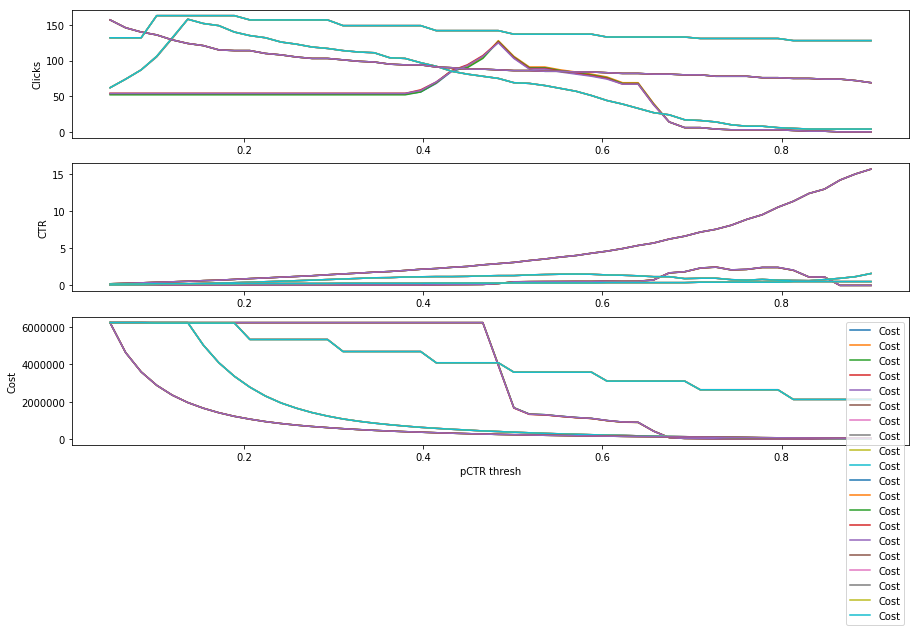

In [29]:
plt.figure(figsize = (15,8))

plt.subplot(3,1,1)
for p in pCTR_model_names:
    for b in basebid_model_names:
        plt.plot(thresh_pCTR, results.loc[(results["pCTR_model"] == p) & (results["basebid_model"] == b), "Clicks"])
        plt.ylabel("Clicks")

        
plt.subplot(3,1,2)
for p in pCTR_model_names:
    for b in basebid_model_names:
        plt.plot(thresh_pCTR, results.loc[(results["pCTR_model"] == p) & (results["basebid_model"] == b), "CTR"])
        plt.ylabel("CTR")
        
        
plt.subplot(3,1,3)
for p in pCTR_model_names:
    for b in basebid_model_names:
        plt.plot(thresh_pCTR, results.loc[(results["pCTR_model"] == p) & (results["basebid_model"] == b), "Cost"])
        plt.ylabel("Cost")
        plt.xlabel("pCTR thresh")
        
plt.legend()

In [19]:
results.loc[(results["pCTR_model"] == "Logistic Regression") & (results["basebid_model"] == "Lasso")]

,Unnamed: 0,pCTR_model,basebid_model,thresh,Impressions,Clicks,Cost,CTR,CPM,CPC
0,0,Logistic Regression,Lasso,0.050000,82376,53,6249967,0.064339,75.871212,117.923906
1,1,Logistic Regression,Lasso,0.067347,82376,53,6249967,0.064339,75.871212,117.923906
2,2,Logistic Regression,Lasso,0.084694,82376,53,6249967,0.064339,75.871212,117.923906
3,3,Logistic Regression,Lasso,0.102041,82376,53,6249967,0.064339,75.871212,117.923906
4,4,Logistic Regression,Lasso,0.119388,82376,53,6249967,0.064339,75.871212,117.923906
5,5,Logistic Regression,Lasso,0.136735,82376,53,6249967,0.064339,75.871212,117.923906
6,6,Logistic Regression,Lasso,0.154082,82376,53,6249967,0.064339,75.871212,117.923906
7,7,Logistic Regression,Lasso,0.171429,82376,53,6249967,0.064339,75.871212,117.923906
8,8,Logistic Regression,Lasso,0.188776,82376,53,6249967,0.064339,75.871212,117.923906
9,9,Logistic Regression,Lasso,0.206122,82376,53,6249967,0.064339,75.871212,117.923906


In [18]:
p,b

('Logistic Regression', 'Lasso')